In [7]:
import pandas as pd
import numpy as np
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import sklearn.tree
import sklearn.ensemble
from sklearn.neural_network import MLPClassifier
import matplotlib.colors as mcolors

In [8]:
# Load in merged SWOT and ice mask data for polygon 01 for 07/19/2025
poly_01 = pd.read_csv("../../../../shared_space/SWOT_Aufeis/joined_SWOT_ice_mask/poly_01_20250719_SWOT_icemask.csv")
poly_01

# Define features and target
features = ['phase_noise_std', 'waterfrac', 'sig0', 'elevation_normalized']
target = ['ice_mask']

# Create X and y
X = poly_01[features]
X = np.array(X)
y = poly_01[target]

# Split data into 80% training and 20% testing
np.random.seed(42)
nsamples = int(len(y) * 0.8)
idx = np.random.choice(y.size,nsamples)
m = np.zeros(y.size).astype(np.int)
m[idx] = 1
m = m.astype(np.bool)
#Divide into training and validation
Xt = X[m,:]
yt = y[m]
Xv = X[~m,:]
yv = y[~m]

In [9]:
# Load in snow mask data
filepath = "../../../../shared_space/SWOT_Aufeis/snow_mask/poly_01_20250719_snow.tif"
snowmask_src = rasterio.open(filepath)
# Read band 1
snowmask_20250603 = snowmask_src.read(1)

In [10]:
# Decision Tree Classifier
clf = sklearn.tree.DecisionTreeClassifier(random_state=1)
#Fit the tree
clf = clf.fit(Xt,yt)
#Assess the accuracy using the training dataset
print('Training Accuracy:',clf.score(Xt, yt))
#Assess the accuracy using the validation dataset
print('Validation Accuracy:',clf.score(Xv,yv))
# Predict on full X to create map later
y_pred_full_clf = clf.predict(X)

Training Accuracy: 1.0
Validation Accuracy: 0.8818643285648362


In [14]:
# Random Forest Classifier
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=1, oob_score=True)
#Fit the tree
rf = rf.fit(X,y)
#Perform 10-fold cross validation to estimate performance
rf_scores = sklearn.model_selection.cross_val_score(rf,X,y,cv=10)
print('Random Forest Accuracy:',np.mean(rf_scores))
# Predict on full X to create map later
y_pred_full = rf.predict(X)
print('Random forest out of bag score:',rf.oob_score_)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

Random Forest Accuracy: 0.9208070554388327
Random forest out of bag score: 0.9317075200799034


In [14]:
mlp = MLPClassifier(random_state=1, hidden_layer_sizes=(200,100),max_iter=500)
#Fit the MLP
mlp = mlp.fit(X, y)
#Perform 10-fold cross validation to estimate performance
mlp_scores = sklearn.model_selection.cross_val_score(mlp,X,y,cv=10)
print('Multilayer Perceptron Accuracy:', np.mean(mlp_scores))
# Predict on full X to create map later
y_pred_full_mlp = mlp.predict(X)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d arr

Multilayer Perceptron Accuracy: 0.9256348918528545


Raster extent: (471980.0, 482640.0, 7683300.0, 7693330.0)


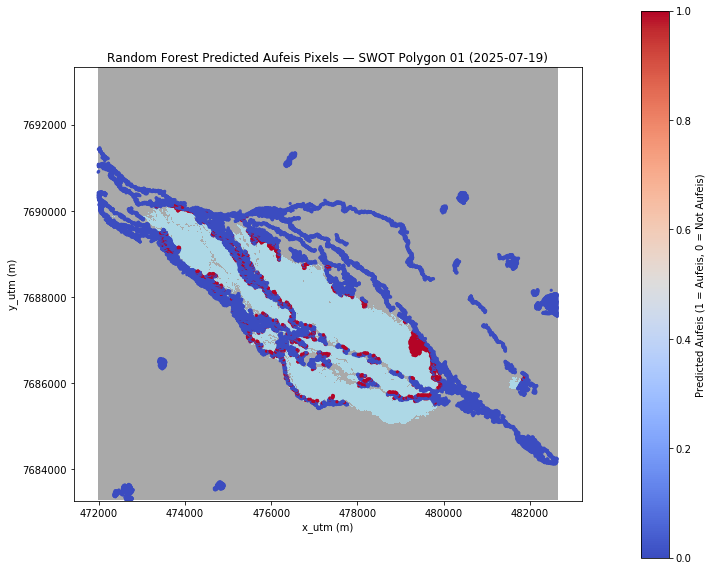

In [26]:
# Plot Random Forest results
# Mask NaNs
raster_to_plot = np.ma.masked_invalid(snowmask_20250603)

# Colormap (0 = dark gray, 1 = light blue)
cmap_raster = mcolors.ListedColormap(['darkgray', 'lightblue'])
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap_raster.N)

# Compute spatial extent from rasterio transform
height, width = snowmask_20250603.shape
minx, miny, maxx, maxy = rasterio.transform.array_bounds(height, width, snowmask_src.transform)
extent = (minx, maxx, miny, maxy)

# --- Prepare points ---
# Make sure y_pred_full corresponds to poly_01 with x_utm, y_utm in same projection
# and that x_utm/y_utm fall roughly within the raster bounds.
print("Raster extent:", extent)

# --- Plot raster + points together ---
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the ice/snow raster background
im = ax.imshow(raster_to_plot, cmap=cmap_raster, norm=norm, extent=extent, origin='upper', interpolation='nearest')

# Overlay the SWOT predicted ice points
sc = ax.scatter(poly_01['x_utm'], poly_01['y_utm'], c=y_pred_full, cmap='coolwarm', s=10, edgecolor='none')

# Labels, titles, legend, etc.
ax.set_xlabel("x_utm (m)")
ax.set_ylabel("y_utm (m)")
ax.set_aspect('equal', adjustable='box')
ax.set_title("Random Forest Predicted Aufeis Pixels — SWOT Polygon 01 (2025‑07‑19)")

# Add both colorbars for clarity
cbar_pred = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.10)
cbar_pred.set_label("Predicted Aufeis (1 = Aufeis, 0 = Not Aufeis)")

plt.tight_layout()
plt.show()

Raster extent: (471980.0, 482640.0, 7683300.0, 7693330.0)


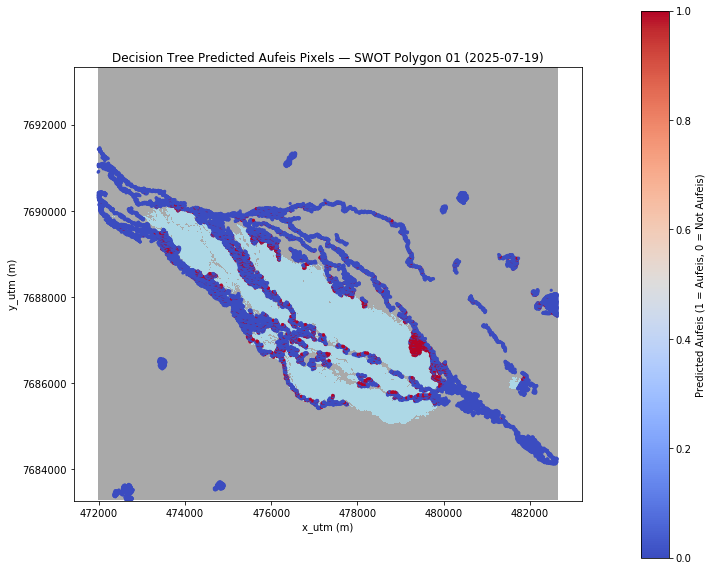

In [12]:
# Plot Decision Tree results
# Mask NaNs
raster_to_plot = np.ma.masked_invalid(snowmask_20250603)

# Colormap (0 = dark gray, 1 = light blue)
cmap_raster = mcolors.ListedColormap(['darkgray', 'lightblue'])
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap_raster.N)

# Compute spatial extent from rasterio transform
height, width = snowmask_20250603.shape
minx, miny, maxx, maxy = rasterio.transform.array_bounds(height, width, snowmask_src.transform)
extent = (minx, maxx, miny, maxy)

# --- Prepare points ---
# Make sure y_pred_full corresponds to poly_01 with x_utm, y_utm in same projection
# and that x_utm/y_utm fall roughly within the raster bounds.
print("Raster extent:", extent)

# --- Plot raster + points together ---
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the ice/snow raster background
im = ax.imshow(raster_to_plot, cmap=cmap_raster, norm=norm, extent=extent, origin='upper', interpolation='nearest')

# Overlay the SWOT predicted ice points
sc = ax.scatter(poly_01['x_utm'], poly_01['y_utm'], c=y_pred_full_clf, cmap='coolwarm', s=10, edgecolor='none')

# Labels, titles, legend, etc.
ax.set_xlabel("x_utm (m)")
ax.set_ylabel("y_utm (m)")
ax.set_aspect('equal', adjustable='box')
ax.set_title("Decision Tree Predicted Aufeis Pixels — SWOT Polygon 01 (2025‑07‑19)")

# Add both colorbars for clarity
cbar_pred = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.10)
cbar_pred.set_label("Predicted Aufeis (1 = Aufeis, 0 = Not Aufeis)")

plt.tight_layout()
plt.show()

Raster extent: (471980.0, 482640.0, 7683300.0, 7693330.0)


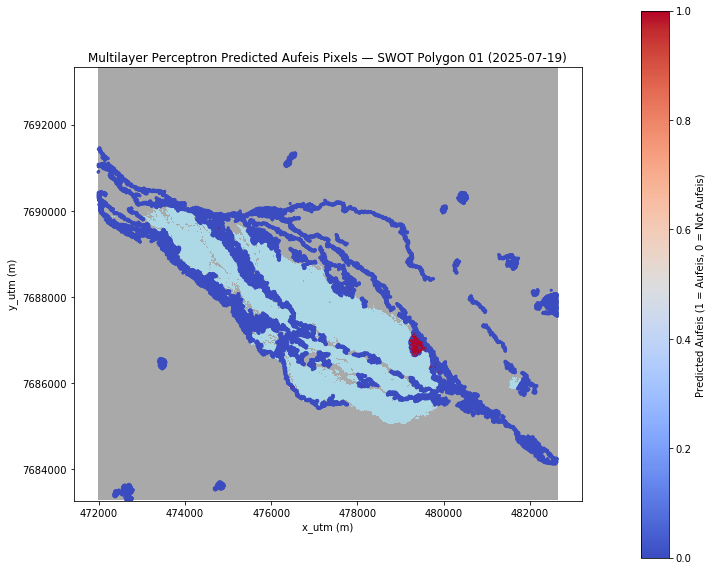

In [16]:
# Plot MLP results
# Mask NaNs
raster_to_plot = np.ma.masked_invalid(snowmask_20250603)

# Colormap (0 = dark gray, 1 = light blue)
cmap_raster = mcolors.ListedColormap(['darkgray', 'lightblue'])
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap_raster.N)

# Compute spatial extent from rasterio transform
height, width = snowmask_20250603.shape
minx, miny, maxx, maxy = rasterio.transform.array_bounds(height, width, snowmask_src.transform)
extent = (minx, maxx, miny, maxy)

# --- Prepare points ---
# Make sure y_pred_full corresponds to poly_01 with x_utm, y_utm in same projection
# and that x_utm/y_utm fall roughly within the raster bounds.
print("Raster extent:", extent)

# --- Plot raster + points together ---
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the ice/snow raster background
im = ax.imshow(raster_to_plot, cmap=cmap_raster, norm=norm, extent=extent, origin='upper', interpolation='nearest')

# Overlay the SWOT predicted ice points
sc = ax.scatter(poly_01['x_utm'], poly_01['y_utm'], c=y_pred_full_mlp, cmap='coolwarm', s=10, edgecolor='none')

# Labels, titles, legend, etc.
ax.set_xlabel("x_utm (m)")
ax.set_ylabel("y_utm (m)")
ax.set_aspect('equal', adjustable='box')
ax.set_title("Multilayer Perceptron Predicted Aufeis Pixels — SWOT Polygon 01 (2025‑07‑19)")

# Add both colorbars for clarity
cbar_pred = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.10)
cbar_pred.set_label("Predicted Aufeis (1 = Aufeis, 0 = Not Aufeis)")

plt.tight_layout()
plt.show()